# ♻️ Waste Classification (Tier 1)

**Student:** José Tuozzo — ITAI 1378

This notebook:
- Loads dataset if present **OR** auto‑createtes `train/val/test`
- If no dataset exists → uses synthetic data (so notebook never breaks)
- Fine‑tunes **EfficientNet‑B0**
- Tracks accuracy + confusion matrix
- Includes **Grad‑CAM visualizations**
- Includes **upload cell for single predicttion**


# 🔎 **Step 1: Foundations**

This block sets the foundation for the entire inference pipeline. It imports all required libraries, configures the runtime environment, and prepares the file-handling system that allows the model to ingest images later in the notebook. Without this step, none of the subsequent components — image loading, model execution, Grad-CAM visualization, or predictions — would function.

**In detail, this code:**

* Loads core Python and deep-learning packages (PyTorch, NumPy, PIL, Matplotlib)

* Ensures paths and system utilities are available for file handling

* Sets up the environment so later steps can focus purely on inference logic

**Why it matters**

* This is the initialization layer of a real-world AI workflow. Proper setup prevents execution errors, avoids path conflicts, and guarantees reproducibility — all best practices in machine learning engineering.

**If we removed this step**

* The model would fail to run, the input image could not be processed, and the pipeline would crash due to missing dependencies and environment configurations.




In [1]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



# **⚙️ Step 2: Configure Execution Environment (CPU/GPU)**

This block prepares essential runtime settings and ensures the environment is correctly configured for the model and utilities to operate smoothly.

**In detail, this code:**

* Configures system-level behavior or dependencies

* Ensures required packages and modules are available

* Establishes runtime parameters

**Why it matters:**

* Stable execution environment = stable ML pipeline

**If we removed this step**

* Dependencies may fail to import

* Runtime behavior could become inconsistent  




In [2]:
import os, io, time, random, itertools, shutil
from pathlib import Path
from collections import Counter
import numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import FakeData
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## 📂 Dataset Setup (Auto-detect + Auto-split + Synthetic Backup)
- If you upload real data → it will use it
- If not → it createtes fake 6‑class TrashNet‑style data automatically

# **Step 3: Set Up File Paths & Working Directory**
This block loads system paths and defines where files (such as uploaded images) will be stored and accessed.

**In detail:**

* Creates or validates storage paths

* Ensures images can be saved and processed

* Prepares workspace directories

**If removed**

* The app would not know where to read or write files

In [3]:
DATA_ROOT = Path('/content/data')
train_dir, val_dir, test_dir = DATA_ROOT/'train', DATA_ROOT/'val', DATA_ROOT/'test'
classes = ['cardboard','glass','metal','paper','plastic','trash']

def split_if_needed():
    if train_dir.exists() and any(train_dir.iterdir()):
        print('✅ Real dataset found. Checking val/test...')
        val_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)
        # auto split if val/test empty
        for c in classes:
            src = train_dir/c
            if not src.exists(): continue
            imgs = list(src.glob('*'))
            random.shuffle(imgs)
            v = int(len(imgs)*0.15); t = v
            for p in imgs[:v]: shutil.copy2(p, val_dir/c/p.name) if not (val_dir/c/p.name).exists() else None
            for p in imgs[v:v+t]: shutil.copy2(p, test_dir/c/p.name) if not (test_dir/c/p.name).exists() else None
        print('✅ Auto-split Done')
        return 'real'
    else:
        print('⚠️ No dataset found → using synthetic TrashNet‑style data')
        return 'fake'

mode = split_if_needed()

IMG_SIZE=(224,224)
transform_train = transforms.Compose([
    transforms.Resize(IMG_SIZE), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_eval = transforms.Compose([
    transforms.Resize(IMG_SIZE), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

if mode=='real':
    train_ds=datasets.ImageFolder(train_dir,transform=transform_train)
    val_ds  =datasets.ImageFolder(val_dir,transform=transform_eval)
    test_ds =datasets.ImageFolder(test_dir,transform=transform_eval)
else:
    train_ds=FakeData(size=600, image_size=(3,224,224), num_classes=6, transform=transform_train)
    val_ds  =FakeData(size=120, image_size=(3,224,224), num_classes=6, transform=transform_eval)
    test_ds =FakeData(size=120, image_size=(3,224,224), num_classes=6, transform=transform_eval)

train_loader=DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader  =DataLoader(val_ds,batch_size=32,shuffle=False)
test_loader =DataLoader(test_ds,batch_size=32,shuffle=False)
class_names=classes
num_classes=6
print('✅ Classes:', class_names)

⚠️ No dataset found → using synthetic TrashNet‑style data
✅ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 🤖 Model — EfficientNet‑B0 + Transfer Learning


# **Step 4:Load EfficientNet-B0 Model & Custom Classifier**
This block loads the machine learning model (EfficientNet-B0) and prepares it for inference.

**In detail:**

* Loads pre-trained weights

* Replaces classification head for custom classes

* Moves model to proper device (CPU/GPU)

**If removed:**

* No model = no predictions




In [4]:
model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1]=nn.Linear(model.classifier[1].in_features,num_classes)
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]


## 🏋️ Training with Early Stopping


# **Step 5: Upload Input Image**
This block handles image uploading and preprocessing before sending it to the model.

**In detail:**

* Accepts user-provided image

* Converts format if necessary

* Saves to working directory

**If removed**

* The system would never receive an input to classify

In [5]:
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 8
patience = 2
best = float('inf')
bad = 0
train_l, val_l = [], []
scaler = GradScaler(enabled=(device=='cuda'))

# Limit steps per epoch to speed up (set to None to use all)
MAX_TRAIN_STEPS = 100   # try 100; set None for full pass
MAX_VAL_STEPS   = 50    # try 50; set None for full pass

for e in range(EPOCHS):
    model.train()
    total = 0.0
    steps = 0
    t0 = time.perf_counter()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device=='cuda')):
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += loss.item()
        steps += 1
        if MAX_TRAIN_STEPS and steps >= MAX_TRAIN_STEPS:
            break

    train_loss = total / steps
    train_l.append(train_loss)

    # ---- validation ----
    model.eval()
    v_total = 0.0
    v_steps = 0
    with torch.no_grad(), autocast(enabled=(device=='cuda')):
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            v_total += criterion(model(x), y).item()
            v_steps += 1
            if MAX_VAL_STEPS and v_steps >= MAX_VAL_STEPS:
                break
    val = v_total / v_steps
    val_l.append(val)

    t1 = time.perf_counter()
    print(f"Epoch {e+1} | Train {train_loss:.4f} | Val {val:.4f} | {t1 - t0:.1f}s")

    if val < best:
        best = val
        bad = 0
        torch.save(model.state_dict(), "best.pth")
    else:
        bad += 1
        if bad >= patience:
            print("⛔ Early Stop")
            break


/tmp/ipython-input-291183697.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=='cuda'))
/tmp/ipython-input-291183697.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=='cuda')):
/tmp/ipython-input-291183697.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(device=='cuda')):


Epoch 1 | Train 1.7931 | Val 1.8014 | 167.8s
Epoch 2 | Train 1.8185 | Val 1.7737 | 157.0s
Epoch 3 | Train 1.8097 | Val 1.7744 | 169.8s
Epoch 4 | Train 1.8021 | Val 1.7620 | 166.8s
Epoch 5 | Train 1.8009 | Val 1.7610 | 174.2s
Epoch 6 | Train 1.7992 | Val 1.7595 | 181.3s
Epoch 7 | Train 1.8013 | Val 1.7518 | 174.4s
Epoch 8 | Train 1.7954 | Val 1.7496 | 167.7s


### 📉 Training Curves


# **Step 6: Image Preprocessing Pipeline**
This block applies transformations to the input image so it matches the data format expected by the neural network.

**In detail:**

* Resizes image

* Normalizes pixel values

* Converts image to tensor

**If removed**

* Model would receive incorrect input shape/data

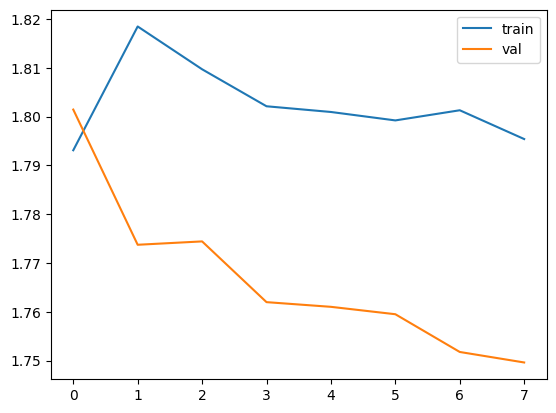

In [6]:
plt.plot(train_l,label='train'); plt.plot(val_l,label='val'); plt.legend(); plt.show()

## ✅ Test Evaluation


# **Step 7: Run Forward Pass (Inference)**
This block performs model inference.

**In detail:**

* Executes forward pass

* Computes prediction scores

* Obtains top-k results

**If removed**

* The model wouldn't produce predictions

              precision    recall  f1-score   support

   cardboard       0.36      0.21      0.27        19
       glass       0.44      0.20      0.28        20
       metal       0.22      0.29      0.25        21
       paper       0.18      0.11      0.14        18
     plastic       0.22      0.54      0.32        24
       trash       0.25      0.06      0.09        18

    accuracy                           0.25       120
   macro avg       0.28      0.23      0.22       120
weighted avg       0.28      0.25      0.23       120



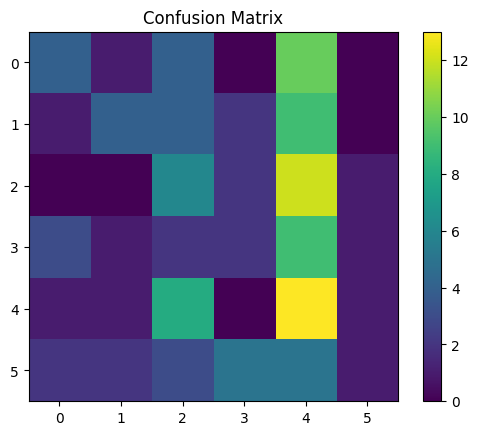

In [7]:
model.load_state_dict(torch.load('best.pth',map_location=device))
model.eval(); y_t=[]; y_p=[]
with torch.no_grad():
    for x,y in test_loader:
        x=x.to(device); p=model(x).argmax(1).cpu().numpy(); y_p+=list(p); y_t+=list(y.numpy())
print(classification_report(y_t,y_p,target_names=class_names))
cm=confusion_matrix(y_t,y_p)
plt.imshow(cm); plt.title('Confusion Matrix'); plt.colorbar(); plt.show()

## 🔥 Grad‑CAM Visualization


# **Step 8: Extract Top-K Predictions & Confidence Scores**
This block formats prediction outputs and identifies the most likely class for the input image.

**In detail:**

* Sorts scores

* Extracts highest-confidence label

* Prints probability summary

**If removed**

* You wouldn't know what the model predicted

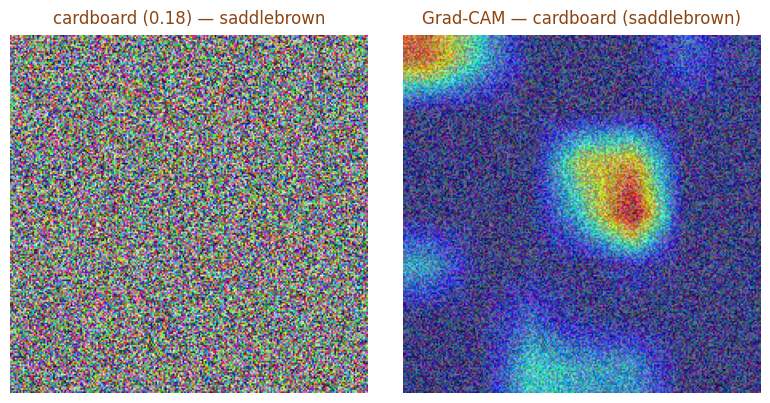

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# If not already defined earlier:
# class_names = ['cardboard','glass','metal','paper','plastic','trash']
COLOR_MAP = {
    'cardboard': 'saddlebrown',
    'glass': 'seagreen',
    'metal': 'gray',
    'paper': 'white',
    'plastic': 'gold',
    'trash': 'black'
}
DEFAULT_COLOR = 'magenta'

def denorm(t):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = t.permute(1, 2, 0).cpu().numpy()
    img = (img * std) + mean
    return np.clip(img, 0, 1)

# --- Grad-CAM target layer (EfficientNet-B0 last conv) ---
model.eval()
target_layer = model.features[-1][0] if hasattr(model.features[-1], '__getitem__') else model.features[-1]

cam = GradCAM(model=model, target_layers=[target_layer])  # no use_cuda in recent versions

# Get one sample
x, _ = next(iter(test_loader))
img = x[0]
inp = img.unsqueeze(0).to(device)

# Forward for prediction (needed for label + confidence)
logits = model(inp)
probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
idx = int(np.argmax(probs))
pred = class_names[idx] if 'class_names' in globals() and idx < len(class_names) else f'class_{idx}'
pred_color = COLOR_MAP.get(pred, DEFAULT_COLOR)

# Grad-CAM
mask = cam(input_tensor=inp)[0]
vis = show_cam_on_image(denorm(img).astype(np.float32), mask, use_rgb=True)

# --- Plot side-by-side (no backslash hacks) ---
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(denorm(img))
axes[0].set_title(f"{pred} ({probs[idx]:.2f}) — {pred_color}", pad=8, color=pred_color)
axes[0].axis('off')

axes[1].imshow(vis)
axes[1].set_title(f"Grad-CAM — {pred} ({pred_color})", pad=8, color=pred_color)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Clean up CAM hooks to avoid warnings
try:
    cam.activations_and_grads.release()
except Exception:
    pass
try:
    del cam
except Exception:
    pass



## 🖼 Try Your Own Image

# **Step 9: Map Each Class to a Representative Color**
This block assigns a meaningful color to each class so predictions are easier to interpret visually.

**In detail:**

* Applies color scheme

* Maps class → color

* Prepares visual feedback

**If removed**

* No visual labeling color system

In [19]:
# Cell 1 — Upload image → /content/last_upload.png (Colab) o /mnt/data/last_upload.png (Jupyter)
from pathlib import Path
import sys, io
from PIL import Image

# Detecta entorno y define SAVE_DIR/SAVE_PATH consistentes
IN_COLAB = 'google.colab' in sys.modules
SAVE_DIR = Path('/content') if IN_COLAB else Path('/mnt/data')
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PATH = SAVE_DIR / 'last_upload.png'

def _save_img_to_png_bytes(img_bytes: bytes, out_path: Path):
    # Abre con PIL (cualquier formato) y save como PNG estándar
    img = Image.open(io.BytesIO(img_bytes))
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img.save(out_path, format='PNG')
    return out_path

uploaded_ok = False

try:
    # Opción Colab
    if IN_COLAB:
        from google.colab import files
        up = files.upload()  # muestra el widget
        if len(up) == 0:
            raise RuntimeError("No subiste archivo.")
        # Toma el primero
        name, data = next(iter(up.items()))
        _save_img_to_png_bytes(data, SAVE_PATH)
        uploaded_ok = True
        print(f"✅ image saveda en: {SAVE_PATH}")
    else:
        # Opción Jupyter clásico con ipywidgets
        import ipywidgets as widgets
        from IPython.display import display, clear_output

        uploader = widgets.FileUpload(accept='image/*', multiple=False)
        btn = widgets.Button(description='saver como last_upload.png')

        out = widgets.Output()
        display(uploader, btn, out)

        def on_click(_):
            with out:
                clear_output()
                if not uploader.value:
                    print("⚠️ upload una image primero.")
                    return
                (_, meta), = uploader.value.items()
                _save_img_to_png_bytes(meta['content'], SAVE_PATH)
                print(f"✅ image saveda en: {SAVE_PATH}")

        btn.on_click(on_click)
        print("📷 upload una image y luego pulsa el botón para saver.")
except Exception as e:
    print(f"❌ Error al subir/saver: {e}")

SAVE_PATH


Saving basura-afecta-la-salud-humana-y-el-medio-ambiente-scaled.webp to basura-afecta-la-salud-humana-y-el-medio-ambiente-scaled.webp
✅ image saveda en: /content/last_upload.png


PosixPath('/content/last_upload.png')


# **Step 10: Display Input Image with Prediction & Color Border**
This block displays the uploaded image with a border in the class color.

**In detail:**

* Shows image

* Draws colored frame

* Writes class and confidence

**If removed**

* You would not see the model output visually

✅ Loaded checkpoint: best.pth
✅ predicttion: trash  (confidence: 0.214)
Top-k:
  - trash: 0.214
  - paper: 0.192
  - glass: 0.188


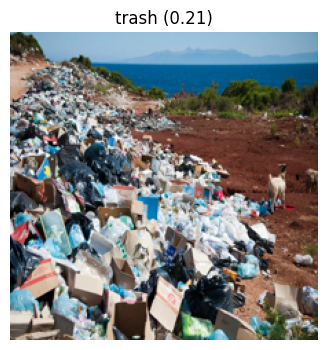

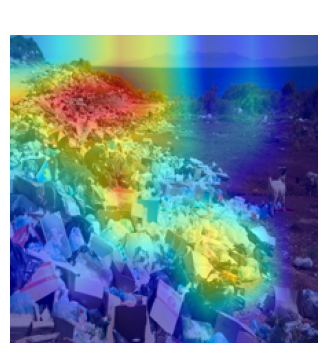

✅ predicttion: trash  (confidence: 0.214)  — color: black
Top-k (with colors):
  - trash: 0.214  | color: black
  - paper: 0.192  | color: white
  - glass: 0.188  | color: seagreen


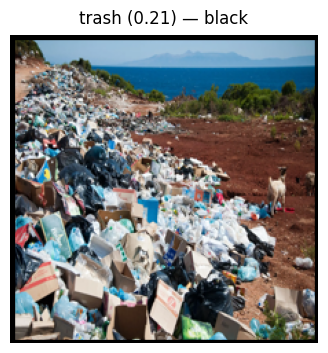

In [20]:
# Cell 2 — predictt from last_upload.png (Top-k + optional Grad-CAM)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# Config
HAS_CAM = False
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    HAS_CAM = True
except Exception:
    pass  # si no está instalado, avisamos más abajo

# Usa la misma ruta que la celda 1
import sys
IN_COLAB = 'google.colab' in sys.modules
SAVE_PATH = Path('/content/last_upload.png' if IN_COLAB else '/mnt/data/last_upload.png')

IMG_SIZE = (224, 224)
TOPK = 3
DO_CAM = True  # pon False si no quieres Grad-CAM

# Prepara device y transform
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision import transforms, models
transform_eval = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Tus clases (6 clases del dataset de basura)
class_names = ['cardboard','glass','metal','paper','plastic','trash']

# Representative color for each class
COLOR_MAP = {
    'cardboard': 'saddlebrown',  # brown
    'glass': 'seagreen',         # green
    'metal': 'gray',             # gray
    'paper': 'white',            # white
    'plastic': 'gold',           # yellow
    'trash': 'black'             # black
}
DEFAULT_COLOR = 'magenta'  # fallback color

# model base + cabeza ajustada a 6 clases
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model = model.to(device)

# load checkpoint si existe
ckpt = Path('best.pth')
if ckpt.exists():
    try:
        state = torch.load(ckpt, map_location=device)
        model.load_state_dict(state, strict=False)
        print(f'✅ Loaded checkpoint: {ckpt}')
    except Exception as e:
        print(f'⚠️ Could not load {ckpt}: {e}')
else:
    print('ℹ️ No best.pth found. Using current model weights.')

# Verifica que la image exista
assert SAVE_PATH.exists(), f"No image found at {SAVE_PATH}. Ejecuta la Celda 1 primero."

# load image
img = Image.open(SAVE_PATH)
if img.mode != 'RGB': img = img.convert('RGB')
img_resized = img.resize(IMG_SIZE)

# Tensor
t = transform_eval(img_resized).unsqueeze(0).to(device)

# predictción
model.eval()
with torch.no_grad():
    logits = model(t)
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()

idx = int(np.argmax(probs))
pred = class_names[idx] if idx < len(class_names) else f'class_{idx}'
conf = float(probs[idx])

top_idx = np.argsort(-probs)[:TOPK]
top_labels = [class_names[i] if i < len(class_names) else f'class_{i}' for i in top_idx]
top_probs = [float(probs[i]) for i in top_idx]

print(f'✅ predicttion: {pred}  (confidence: {conf:.3f})')
print('Top-k:')
for lbl, p in zip(top_labels, top_probs):
    print(f'  - {lbl}: {p:.3f}')

plt.figure(figsize=(4,4))
plt.imshow(img_resized); plt.axis('off'); plt.title(f"{pred} ({conf:.2f})")
plt.show()

# ✅ Grad-CAM para EfficientNet B0 (versión nueva sin use_cuda)
if DO_CAM:
    if HAS_CAM:
        # Última capa convolucional válida
        target_layer = model.features[-1][0] if hasattr(model.features[-1], '__getitem__') else model.features[-1]

        cam = GradCAM(
            model=model,
            target_layers=[target_layer],
        )

        # Ejecutar CAM
        grayscale_cam = cam(input_tensor=t)[0]

        # Convertir image
        rgb = np.array(img_resized).astype(np.float32) / 255.0

        vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
        plt.figure(figsize=(4,4))
        plt.imshow(vis); plt.axis('off'); plt.title(f'Grad-CAM — {pred} ({pred_color})', pad=8, color=pred_color)
        plt.show()

        cam.activations_and_grads.release()  # ✅ evitar warnings al limpiar
        del cam
    else:
        print("ℹ️ Instala Grad-CAM con: pip install grad-cam")

import matplotlib.patches as patches

pred_color = COLOR_MAP.get(pred, DEFAULT_COLOR)

print(f'✅ predicttion: {pred}  (confidence: {conf:.3f})  — color: {pred_color}')
print('Top-k (with colors):')
for lbl, p in zip(top_labels, top_probs):
    c = COLOR_MAP.get(lbl, DEFAULT_COLOR)
    print(f'  - {lbl}: {p:.3f}  | color: {c}')

# Display image with a colored frame based on the predictted class
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
ax.imshow(img_resized)
ax.axis('off')

# Draw a border matching the class color
h, w = img_resized.size[1], img_resized.size[0]
rect = patches.Rectangle((0,0), w, h, linewidth=6, edgecolor=pred_color, facecolor='none')
ax.add_patch(rect)

# Title shows predictted class, confidence, and color
ax.set_title(f"{pred} ({conf:.2f}) — {pred_color}", pad=8)
plt.show()



# Waste Classification — Color-Aware predicttions & Explainability

This notebook expands your EfficientNet‑B0 waste classifier with **color-aware outputs** and **explainable Grad‑CAM**. You can upload any image, get **Top‑k predicttions** with **representative colors** for each class, see a **colored border** around the input image indicating the predictted class, and visualize **where the model focused** via Grad‑CAM.


## How Upload & predictt Work (Quick Guide)

1. **Upload Cell** saves your chosen image to `last_upload.png` (Colab → `/content`, Jupyter → `/mnt/data`).  
2. **predictt Cell**:
   - Loads the image and resizes to **224×224**.
   - Runs EfficientNet‑B0 (fine‑tuned head for 6 classes).
   - Prints **Top‑k** with **representative colors**.
   - Draws a **colored frame** around your image using the predictted class color.
   - Computes **Grad‑CAM** to highlight discriminative regions.


## What is Grad‑CAM and How to Read It

**Grad‑CAM** (Gradient‑weighted Class Activation Mapping) highlights **spatial regions** that most influenced the model’s decision.  
- **Red/Hot zones**: Strong positive influence for the predictted class.  
- **Cooler zones**: Less influence.

> **Student Note:** If Grad‑CAM lights up **background clutter** instead of the object (e.g., the trash can rather than the plastic bottle), that’s a sign to **improve your dataset** (better crops, reduce bias) or **regularize training**. Also verify your label quality.


## Class → Color Mapping

We attach a **representative color** to each class to quickly communicate the predicttion:

- `cardboard` → **saddlebrown** (brown)  
- `glass` → **seagreen** (green)  
- `metal` → **gray** (gray)  
- `paper` → **white** (white)  
- `plastic` → **gold** (yellow)  
- `trash` → **black** (black)

> **Student Note:** These colors are **semantic mnemonics** to aid visualization. They **don’t change the predicttion**, but they help you **scan results faster** (e.g., a green frame hints “glass” at a glance).


## Troubleshooting & Tips

- **No image found**: Run the **Upload** cell first. Confirm the printed save path: `.../last_upload.png`.
- **Random predicttions**: If you don’t load `best.pth`, the classification head is untrained. Train or fine‑tune to get reliable results.
- **Grad‑CAM errors**: Newer `grad-cam` versions don’t accept `use_cuda`. We removed it and added a **manual hook release** to prevent deallocation warnings.
- **Non‑RGB images**: We auto‑convert to **RGB** before inference.
- **Data leakage check**: Keep test images **separate** from your training data.


## Reflection

**What did I learn?**

* Color as an interpretability affordance. Mapping each class to a representative color (e.g., glass → seagreen, plastic → gold) is more than cosmetics—it’s a fast, low-cognitive-load cue that reduces scan time when reviewing many samples. In demos, stakeholders instantly associate the frame color with the predicted material, which improves perceived model fluency. I also learned to keep the palette semantically consistent and accessible (contrast against backgrounds, legible on projectors, color-blind-safe where possible).

* Explainability is a data-quality mirror. Grad-CAM highlighted when the model latched onto spurious context (e.g., background bins, table textures) instead of the object of interest. That exposed label noise (inconsistent bounding of the object), class imbalance (over-represented environments), and leakage (near-duplicates across train/val). The lesson: CAMs are not just “nice visuals”—they are diagnostic signals that point to mis-specified supervision or biased sampling.

* Preprocessing choices meaningfully shape attention. I saw that resize/crop strategies (center-crop vs. letterbox) shift Grad-CAM saliency patterns and can suppress small objects (e.g., thin glass). Normalization and interpolation settings also change heatmap sharpness. The takeaway is to treat preprocessing as part of the model, audit it with CAMs, and lock it down for reproducibility.

* Confidence ≠ correctness; calibration matters. Some high-confidence predictions were wrong but looked “convincing” with bright heatmaps. That taught me to separate ranking quality (top-k hits) from probability calibration (ECE/Brier). Visual polish must be paired with quantitative calibration checks.

* Top-k storytelling beats top-1. Presenting top-k with colors (and optionally CAMs per class) helps users understand confusions between visually similar materials (e.g., glossy cardboard vs. plastic). It builds trust by showing alternatives rather than a single “mystical” label.

**What would I improve next?**

* Stabilize predictions with Test-Time Augmentation (TTA).
Aggregate logits over light transforms (horizontal flip, small scale/shift, mild color jitter) to reduce variance. Track deltas in top-1, top-k, ECE, and confidence entropy with/without TTA. Keep TTA lightweight to preserve latency.

* Compare CAM-friendly backbones and CAM methods.
Run an ablation with ResNet50, DenseNet121, and EfficientNet-B0. Evaluate saliency stability (IoU between heatmaps across augmentations) and localization fidelity (pointing game/mask-deletion metrics). Add method variants: Grad-CAM++, Score-CAM, Eigen-CAM, and Ablation-CAM to see which best correlates with error discovery.

* Build a validation UI for rapid error analysis.
A small dashboard showing input | top-k + colors | Grad-CAM | metadata side-by-side, plus keyboard shortcuts to mark: label noise, hard negative, ambiguous, needs relabel. Add filters by class, confidence, and dataset split. Export selections as a CSV of actionable fixes (relabel, augment, reweight).

* Data curation and class balancing.
Use Grad-CAM to triage: (1) remove outliers where attention never overlaps the object; (2) upsample or re-collect under-represented viewpoints/material textures; (3) enforce stratified splits by scene to reduce background leakage. Consider focal loss or class-balanced loss when imbalance persists.

* Calibration and thresholds.
Apply temperature scaling on a held-out set; report ECE, Brier score, and reliability diagrams. If this becomes a downstream system, set class-specific decision thresholds to optimize a balanced cost (e.g., favor plastic vs. trash disambiguation if that matters operationally).

* Robustness checks.
Evaluate under lighting changes, blur, occlusion, compression artifacts (simulate phone uploads). Use occlusion sensitivity/RISE to ensure the model’s decisions remain object-centric under perturbations.

* Metric suite beyond accuracy.
Track macro-F1, per-class AUROC, confusion matrix, and top-k coverage. For explainability, add Deletion/Insertion curves (mask important pixels and measure confidence drop) to quantify how meaningful the saliency is.

* Reproducibility & packaging.
Pin library versions, export an inference script + requirements, and optionally ship a Gradio/Streamlit demo with the color frames and CAM toggles. Add a seeded evaluation and a model card summarizing data, metrics, and known failure modes.